In [1]:
import ast
import pickle
import re

import numpy as np
import pandas as pd
import torch
from sklearn.utils import gen_batches
from tqdm.notebook import tqdm

## Visualization. Here's where we produce all the plots for the paper

In [2]:
# Here's how we'll plot data

import matplotlib.pyplot as plt
import seaborn as sns


def plot_umap(X, labels=None, save=None, s=0.1, dpi=400):
    """X is a (N, 2) dimensional array (from e.g. UMAP)
    `labels` is a list with labels for each point
    """
    fig, ax = plt.subplots(figsize=(15, 15))

    sns.scatterplot(
        x=X[:, 0], y=X[:, 1], hue=labels, ax=ax, s=s, marker=".", palette="hsv"
    )

    for side in ["left", "right", "top", "bottom"]:
        ax.spines[side].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

    if save:
        fig.savefig(save, dpi=dpi)

    plt.show()
    return fig

## First get UMAPs for each segment class

In [3]:
# Load metadatas dict
with open("../../data/processed/sg_db_clean.bin", "rb") as f:
    sg_db = pickle.load(f)

In [4]:
import gc

gc.collect()

from umap import UMAP


def get_umap_x(embs, cl):
    umap_2d = UMAP(
        n_components=2,
        init="pca",
        n_jobs=20,
        n_neighbors=20,
        min_dist=0.001,
        metric="cosine",
        tqdm_kwds={"disable": False},
    )

    X_s_cl = umap_2d.fit_transform(embs.numpy())
    del umap_2d

    torch.save(X_s_cl, f"../../data/processed/umap/UMAP_{cl}_full.pt")
    return X_s_cl

In [5]:
%%time

# Calculate for each segment class
sgm_cls = np.array([s["sgm_cls"] for s in sg_db])
del sg_db  # For memory

classes = ["reaction set-up", "work-up", "purification", "analysis"]
for i, cl in tqdm(enumerate(classes), total=len(classes)):
    # Load subset and make map
    cl = re.sub(" |-", "_", cl)

    embeds = torch.load(f"../../data/processed/embeds/segm_embs_{cl}.pt")
    get_umap_x(embeds, cl)

    del embeds
    gc.collect()

# Calculate for rxnfps
embeds = torch.load("../../data/rxn_embeds_clean.pt")
get_umap_x(embeds, "rxnfp")

  0%|          | 0/4 [00:00<?, ?it/s]

Epochs completed:   0%|            0/200 [00:00]

Epochs completed:   0%|            0/200 [00:00]

Epochs completed:   0%|            0/200 [00:00]

Epochs completed:   0%|            0/200 [00:00]

Epochs completed:   0%|            0/200 [00:00]

CPU times: user 4h 21min 10s, sys: 9min 28s, total: 4h 30min 38s
Wall time: 17min 13s


array([[-2.8028238,  5.2471337],
       [-7.535083 , 13.742067 ],
       [12.240716 ,  6.8567777],
       ...,
       [-5.2815976,  6.0664554],
       [ 1.2399119,  0.8564153],
       [10.250134 ,  5.4866247]], dtype=float32)

## Get rxn class labels and plot the UMAPs.

In [4]:
# Load metadatas dict
with open("../../data/processed/sg_db_clean.bin", "rb") as f:
    sg_db = pickle.load(f)

sg_df = pd.DataFrame(sg_db)
sg_df.rxn_smi = sg_df.rxn_smi.fillna(method="ffill")
sg_df.head()

txt_sgm  src_prg  \
0  Suspend anhydrous AlCl3 (156 g, 1.15 mol) in t...        0   
1  decant the toluene and extract the aqueous pha...        0   
2  Evaporate the solvent in vacuo to give the tit...        0   
3  Dissolve 4-chloro-1-(4-isopropyl-phenyl)-butan...        1   
4  Add, by dropwise addition, a solution of sodiu...        1   

           sgm_cls  stp_ord  \
0  reaction set-up        1   
1          work-up        2   
2     purification        3   
3  reaction set-up        1   
4          work-up        2   

                                             rxn_smi  \
0  [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...   
1  [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...   
2  [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...   
3  [Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...   
4  [Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...   

                                             prd_str  
0         [4-Chloro-1-(4-methyl-phenyl)-butan-1-one]  
1                                                NaN  
2                                                NaN  
3  [1-[4-(1-Bromo-1-methyl-ethyl)-phenyl]-4-chlor...  
4                                                NaN

In [18]:
from rxn.chemutils.miscellaneous import canonicalize_any
from rxn.chemutils.utils import remove_atom_mapping

tqdm.pandas()


def preproc_rxn(smi):
    u = re.sub("\|f.*", "", smi).strip()
    u = remove_atom_mapping(u)
    try:
        return canonicalize_any(u)
    except:
        return "C>>C"


# Get unique rxns and map
unique_smis = pd.DataFrame(sg_df.rxn_smi.unique(), columns=["rxn_smi"])

unique_smis["canon_smi"] = unique_smis["rxn_smi"].progress_apply(preproc_rxn)

unique_smis["canon_smi"].to_csv(
    "../../data/processed/uniq_rxnsmi.smi", index=False, header=None
)

  0%|          | 0/665265 [00:00<?, ?it/s]

In [136]:
# After mapping with namerxn, load file
rxn_classes = pd.read_csv(
    "../../data/processed/uniq_rxnsmi_cls.smi",
    header=None,
    names=["rxn_smi", "class"],
    sep=" ",
)
unique_smis["class"] = rxn_classes["class"]

# Merge with sg_df
sg_df_ = pd.merge(
    sg_df, unique_smis, left_on="rxn_smi", right_on="rxn_smi", how="left"
)

In [137]:
rxn_class_map = {
    0: "Unassigned",
    1: "Heteroatom alkylation/arylation",
    2: "Acylation",
    3: "C-C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "FGI",
    10: "FGA",
    11: "Resolution",
    12: "Miscelaneous",
}

# Extract only first class
sg_df_["cls_1"] = sg_df_["class"].apply(
    lambda x: rxn_class_map[int(x.split(".")[0])]
)

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_1493313/4269346443.py:31: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/andres/anaconda3/envs/jasyntho/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



/tmp/ipykernel_1493313/4269346443.py:31: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/andres/anaconda3/envs/jasyntho/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



/home/andres/anaconda3/envs/jasyntho/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



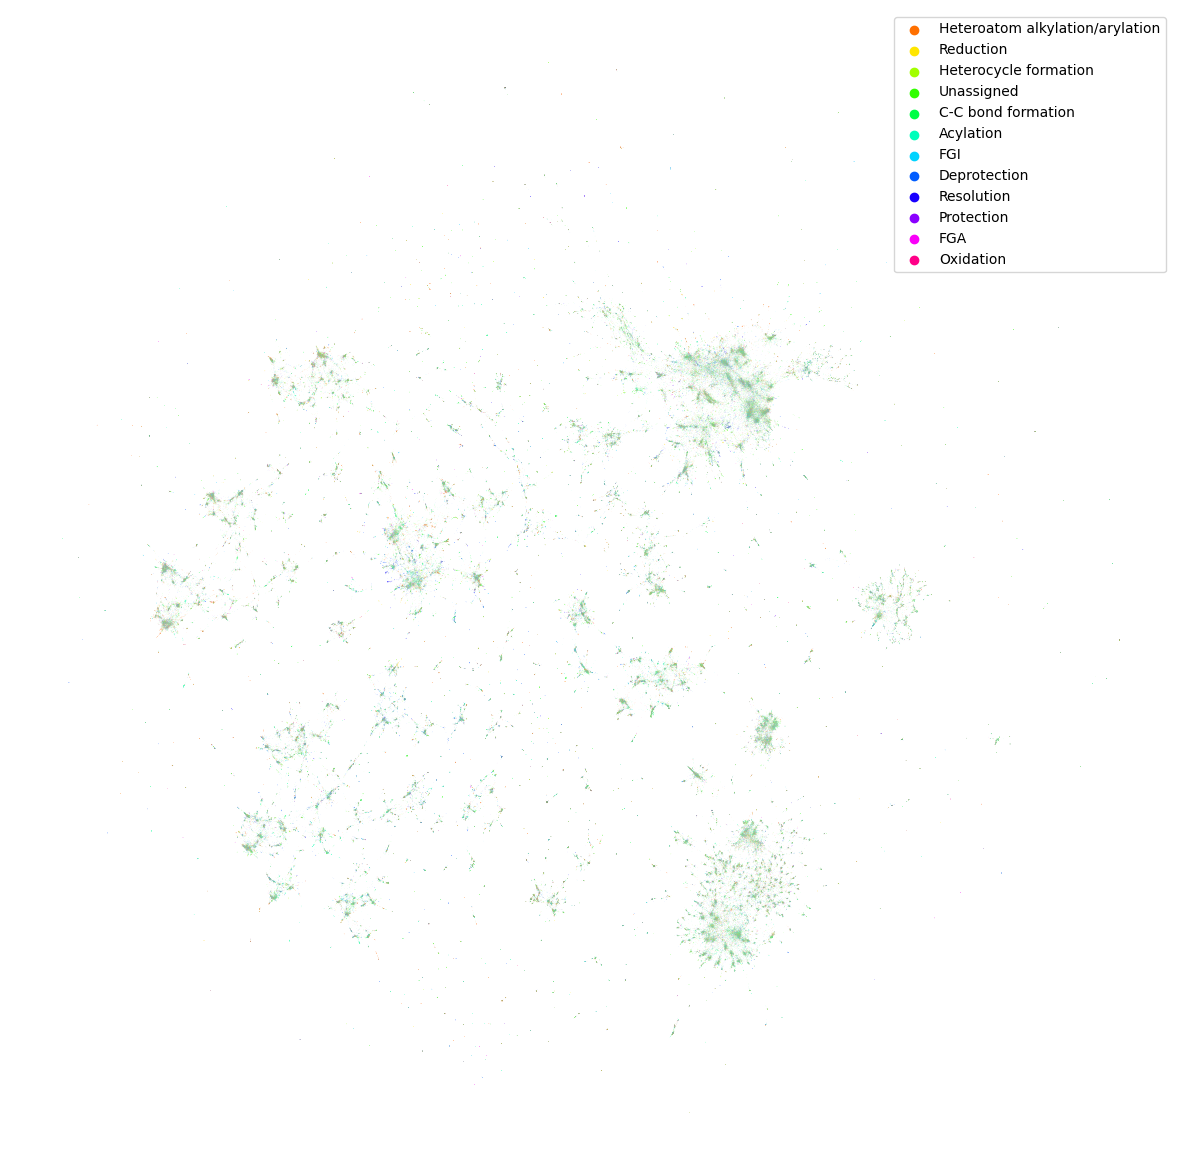

/home/andres/anaconda3/envs/jasyntho/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



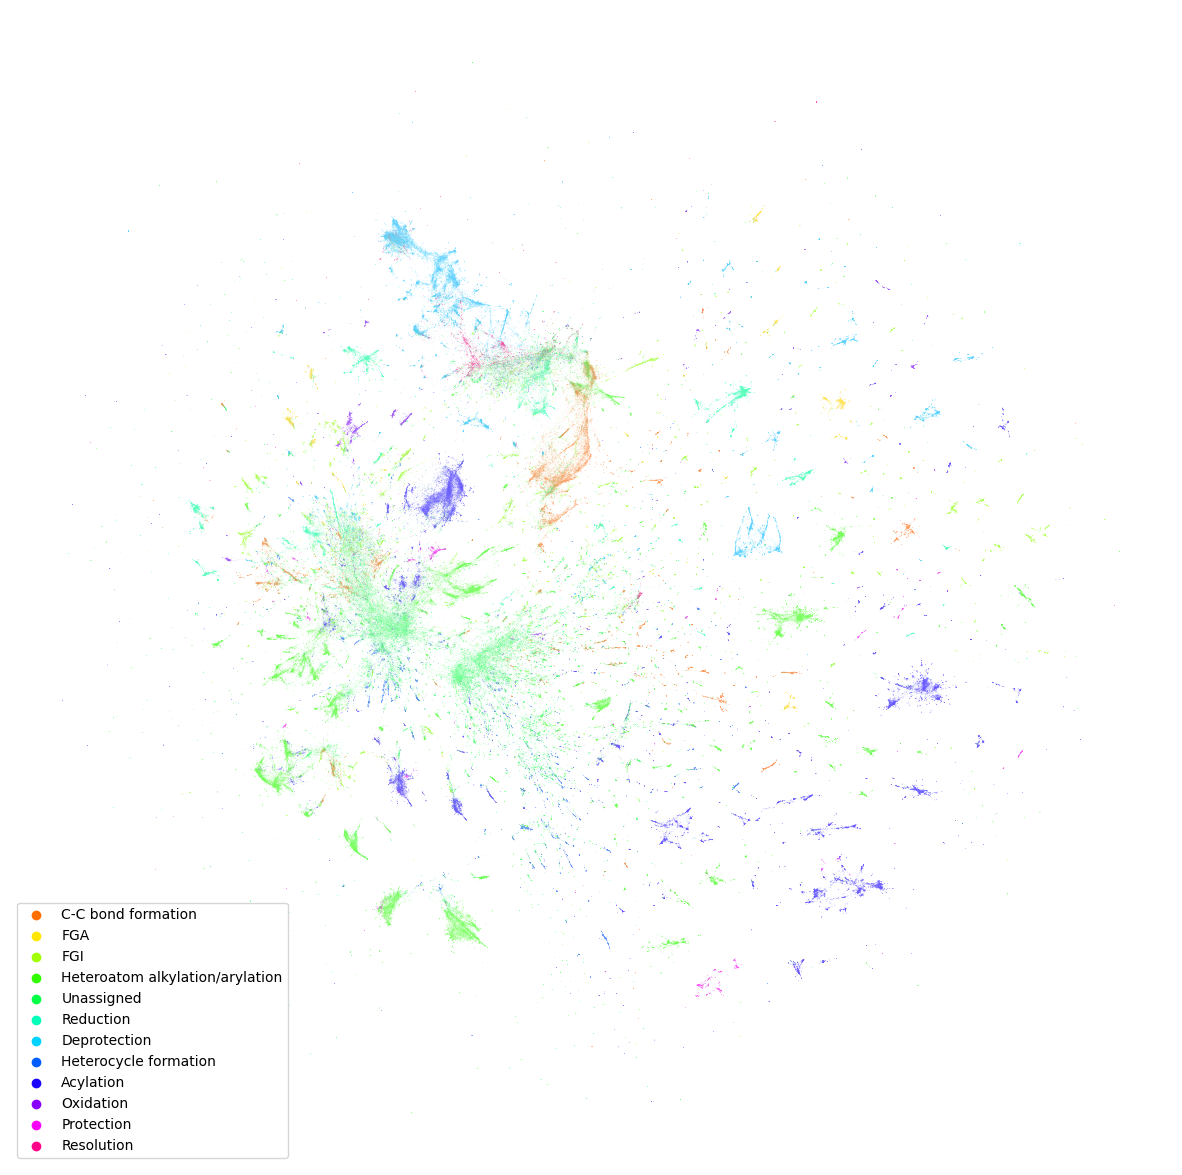

In [138]:
# Plot each segment class, with reaction classes

# Calculate for each segment class
sgm_cls = np.array([s["sgm_cls"] for s in sg_db])

figs = []
classes = ["reaction set-up", "work-up", "purification", "analysis"]
for i, cl in tqdm(enumerate(classes), total=len(classes)):
    # Load subset and make map
    cl_ = re.sub(" |-", "_", cl)

    Xs = torch.load(f"../../data/processed/umap/UMAP_{cl_}_full.pt")
    labels = sg_df_.loc[sg_df_["sgm_cls"] == cl, "cls_1"].values
    fig = plot_umap(
        Xs, labels=labels, save=f"../plots/{cl}_full_rxncls.png", dpi=600
    )
    figs.append(fig)

# Also for rxnfps
Xs = torch.load(f"../../data/processed/umap/UMAP_rxnfp_full.pt")
labels = sg_df_.loc[sg_df_["sgm_cls"] == classes[0], "cls_1"].values
fig = plot_umap(Xs, labels=labels)
figs.append(fig)

## Let's now try to visualize by yield

In [140]:
# Here are the datasets that contain all data - including yield

uspto_csv_1 = pd.read_csv(
    "../../data/raw/Extracted_Data_2001_Sep2016_USPTOapplications_new.csv",
    low_memory=False,
)
uspto_csv_2 = pd.read_csv(
    "../../data/raw/Extracted_Data_1976_Sep2016_USPTOgrants_new.csv",
    low_memory=False,
)
uspto_csv = pd.concat([uspto_csv_1, uspto_csv_2]).drop_duplicates(
    subset=["Reaction Smiles", "Yield"]
)
print(uspto_csv.shape)

(1495101, 11)


In [141]:
def proc_yield(v):
    # First convert every value to float
    def _proc_y(y):
        try:
            transf = float(y.strip("%").strip("="))
            if transf > 0 and transf < 100:
                return transf
            return np.nan
        except:
            return np.nan

    v = [_proc_y(y) for y in v]
    return np.nanmax(v)


yields = (
    uspto_csv.groupby("Reaction Smiles")["Yield"]
    .apply(proc_yield)
    .reset_index()
)

yields.head

/tmp/ipykernel_1493313/1300793243.py:13: RuntimeWarning:

All-NaN axis encountered



<bound method NDFrame.head of                                            Reaction Smiles  Yield
0        B#B.C(O)(=O)C.C([O:10][C@H:11]1[CH2:28][CH2:27...    NaN
1        B#B.C1COCC1.[Br:8][C:9]1[CH:10]=[C:11]([CH2:15...    NaN
2        B#B.C1COCC1.[CH3:8][C:9]([C:16]([F:19])([F:18]...    NaN
3        B#B.CSC.[CH3:6][C:7]1([CH3:40])[C:11](=[O:12])...    NaN
4        B#B.O1CCCC1.[Cl:8][C:9]1[C:21]([O:22][CH3:23])...    NaN
...                                                    ...    ...
1484428  [Zr:1].[CH2:2]([OH:88])[C@H:3]1[O:8][C@@H:7]2[...    NaN
1484429  [Zr:1].[O:2]=[Sb:3][O:4][Sb:5]=[O:6]>>[O:2]=[S...    NaN
1484430  [Zr:1].[O:2]=[Sb:3][O:4][Sb:5]=[O:6]>>[OH-:2]....    NaN
1484431  [Zr:1].[P:2](=[O:6])([OH:5])([OH:4])[OH:3]>>[P...    NaN
1484432  [Zr:1].[P:2](=[O:6])([OH:5])([OH:4])[OH:3]>O>[...    NaN

[1484433 rows x 2 columns]>

In [142]:
# Merge with sg_df
sg_df_ = pd.merge(
    sg_df, yields, left_on="rxn_smi", right_on="Reaction Smiles", how="left"
)

sg_df_["Yield bin"] = pd.cut(sg_df_["Yield"].fillna(0), 10)
sg_df_.head()

txt_sgm  src_prg  \
0  Suspend anhydrous AlCl3 (156 g, 1.15 mol) in t...        0   
1  decant the toluene and extract the aqueous pha...        0   
2  Evaporate the solvent in vacuo to give the tit...        0   
3  Dissolve 4-chloro-1-(4-isopropyl-phenyl)-butan...        1   
4  Add, by dropwise addition, a solution of sodiu...        1   

           sgm_cls  stp_ord  \
0  reaction set-up        1   
1          work-up        2   
2     purification        3   
3  reaction set-up        1   
4          work-up        2   

                                             rxn_smi  \
0  [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...   
1  [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...   
2  [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...   
3  [Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...   
4  [Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...   

                                             prd_str  \
0         [4-Chloro-1-(4-methyl-phenyl)-butan-1-one]   
1                                                NaN   
2                                                NaN   
3  [1-[4-(1-Bromo-1-methyl-ethyl)-phenyl]-4-chlor...   
4                                                NaN   

                                     Reaction Smiles  Yield        Yield bin  
0  [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...   95.0  (89.991, 99.99]  
1  [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...   95.0  (89.991, 99.99]  
2  [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...   95.0  (89.991, 99.99]  
3  [Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...   99.0  (89.991, 99.99]  
4  [Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...   99.0  (89.991, 99.99]

  0%|          | 0/4 [00:00<?, ?it/s]

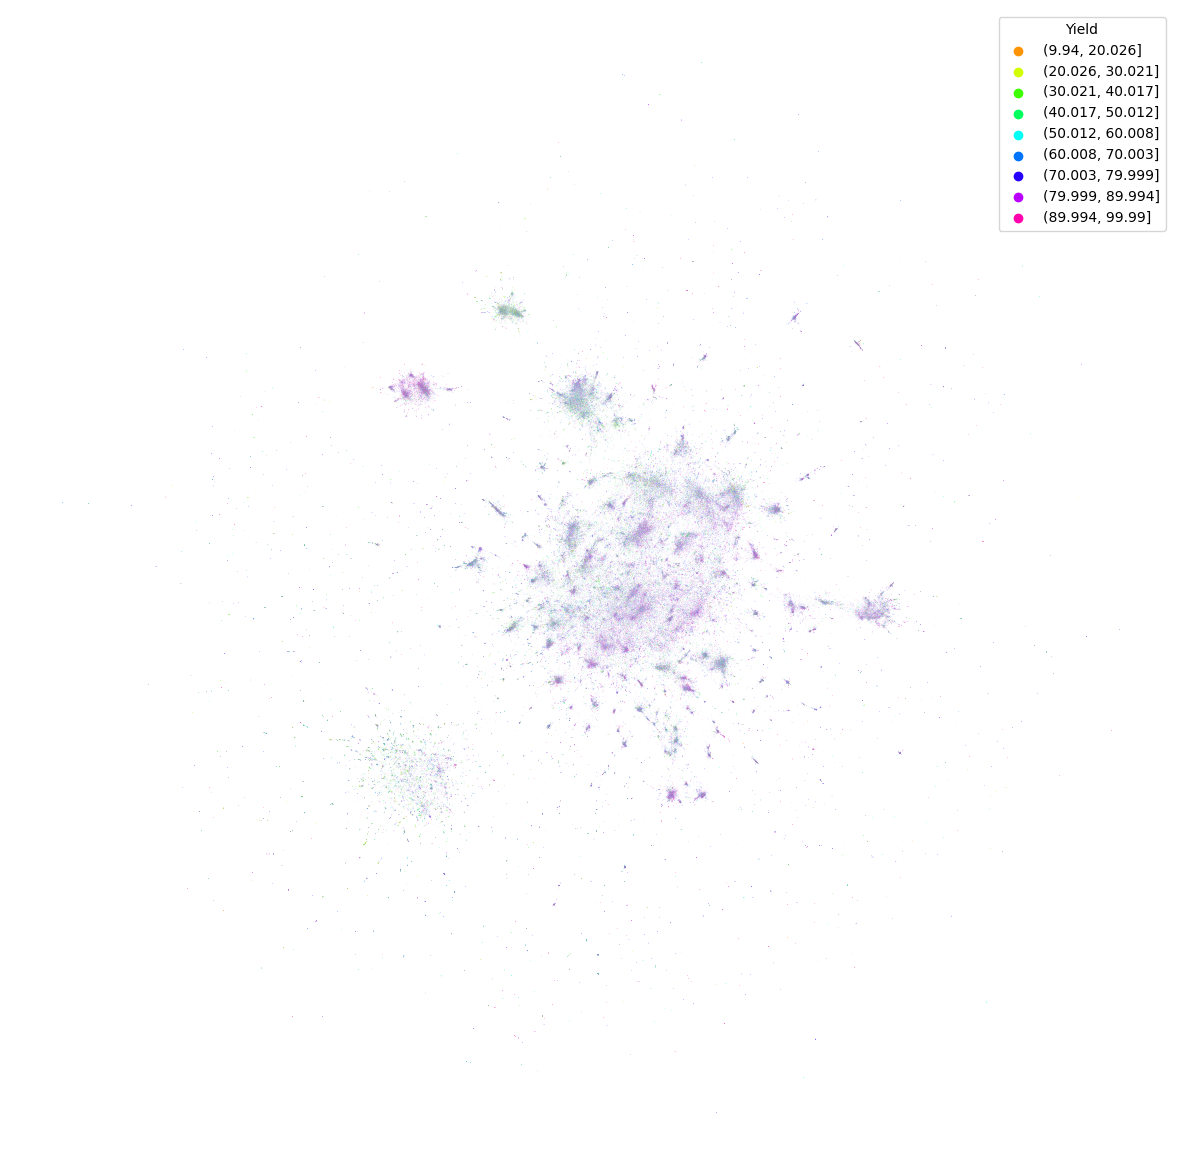

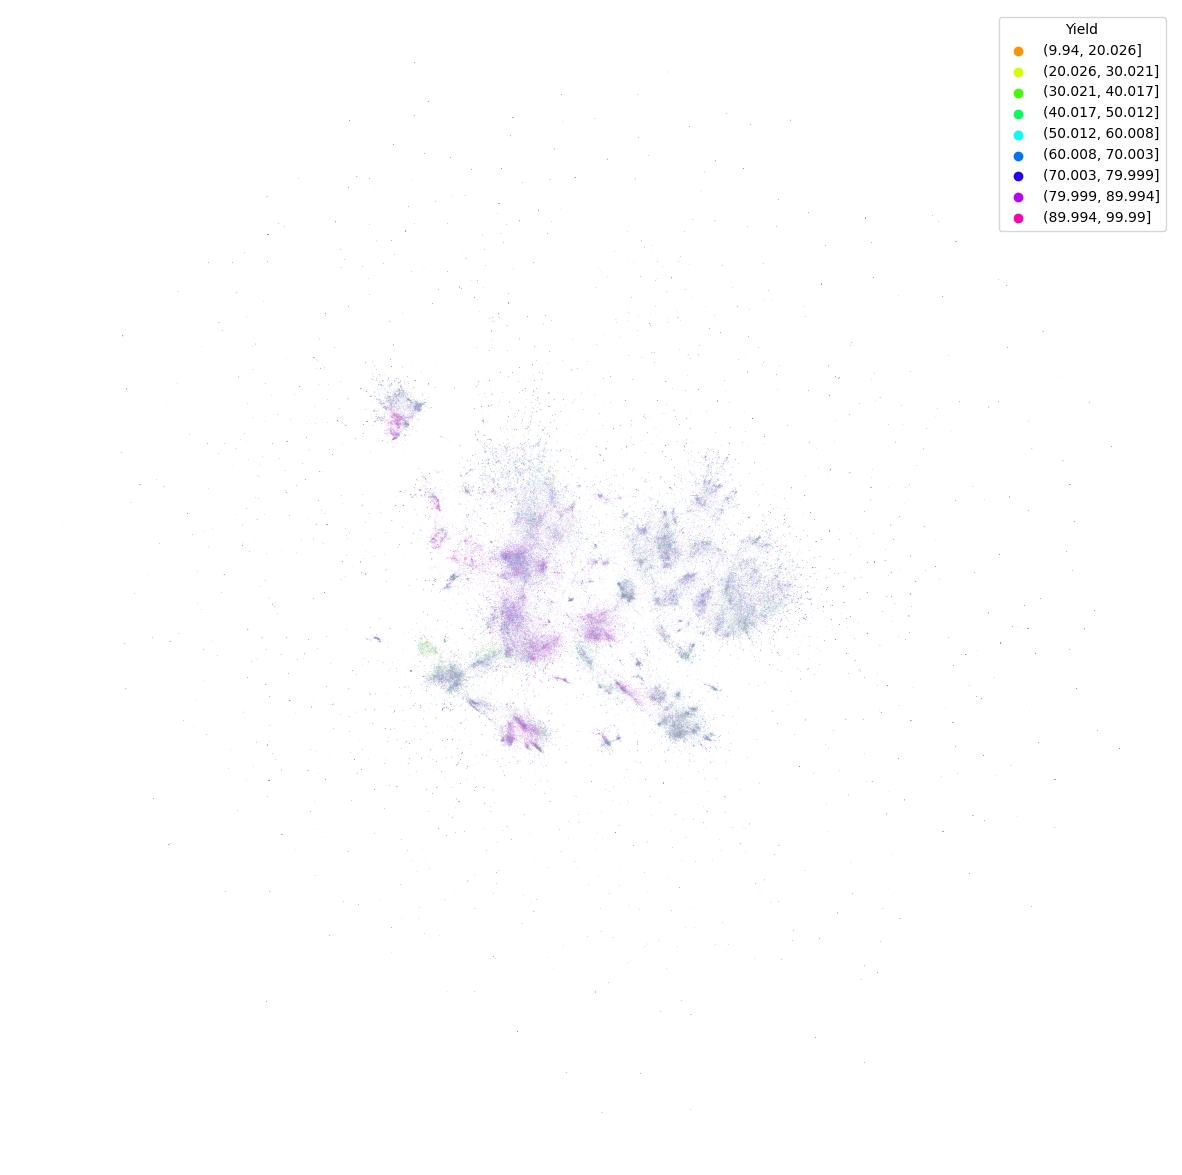

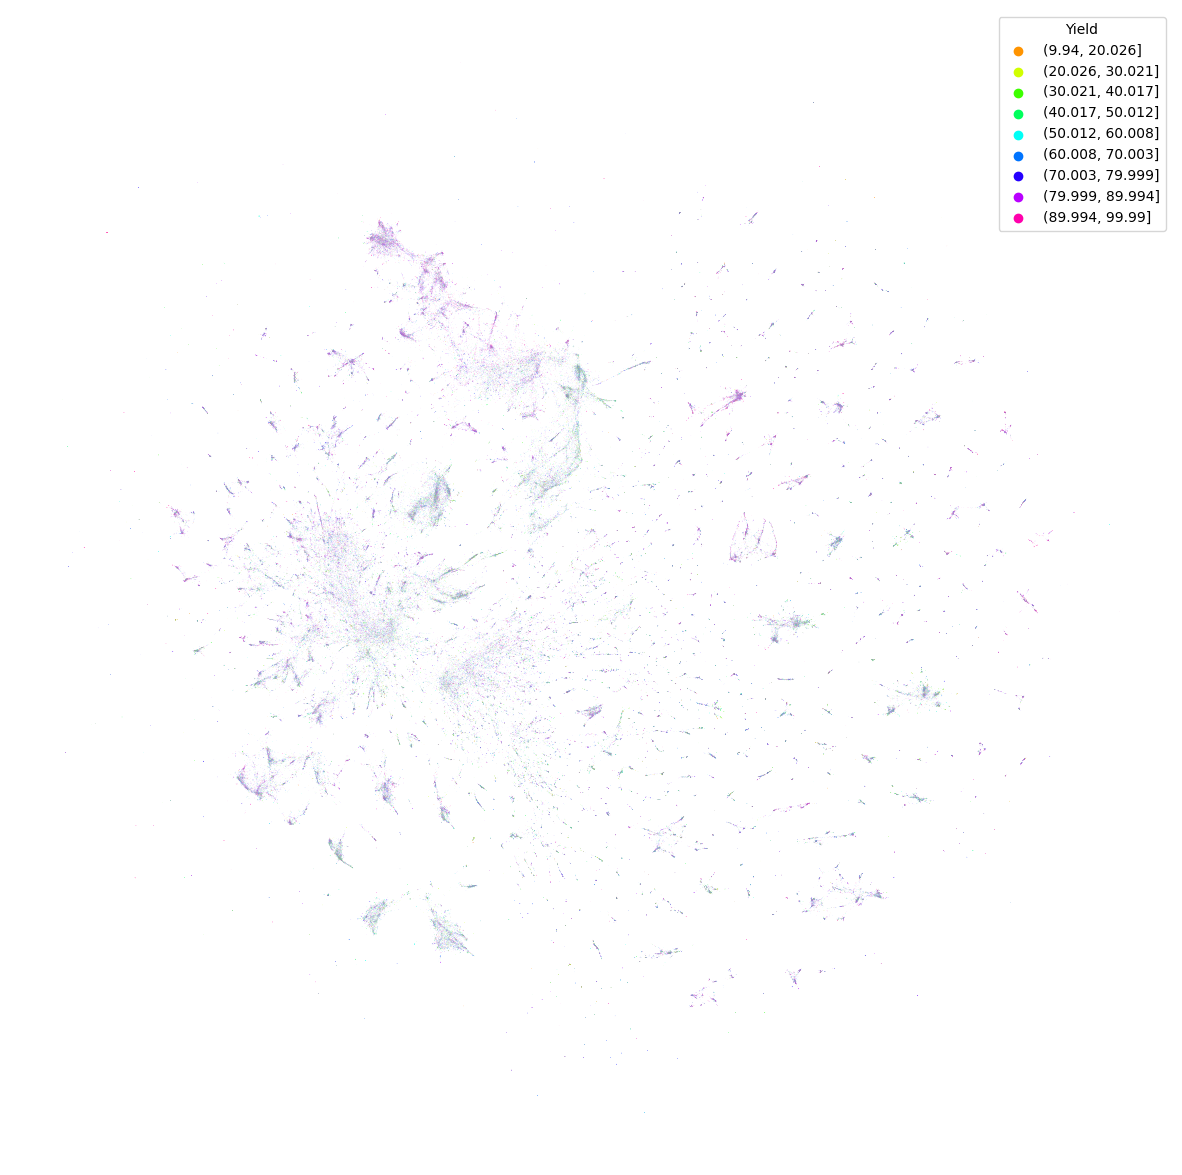

In [143]:
# Plot each segment class, with yields

# Calculate for each segment class
sgm_cls = np.array([s["sgm_cls"] for s in sg_db])

figs = []
classes = ["reaction set-up", "work-up", "purification", "analysis"]
for i, cl in tqdm(enumerate(classes), total=len(classes)):
    # Load subset and make map
    cl_ = re.sub(" |-", "_", cl)

    Xs = torch.load(f"../../data/processed/umap/UMAP_{cl_}_full.pt")
    labels = sg_df_.loc[sg_df_["sgm_cls"] == cl, "Yield"]

    # Get only those with yield > 0
    discr = (labels > 10) * (~labels.isna())
    Xs = Xs[discr]
    labels = pd.cut(labels[discr], 9)

    fig = plot_umap(
        Xs, labels=labels, save=f"../plots/{cl}_full_yield.png", dpi=600
    )
    figs.append(fig)

# Also for rxnfps
Xs = torch.load(f"../../data/processed/umap/UMAP_rxnfp_full.pt")
labels = sg_df_.loc[sg_df_["sgm_cls"] == classes[0], "Yield"]

# Get only those with yield > 0
discr = (labels > 10) * (~labels.isna())
Xs = Xs[discr]
labels = pd.cut(labels[discr], 9)

fig = plot_umap(Xs, labels=labels)
figs.append(fig)

## Finally, make an interactive plot to more closely explore the structure of each space.

In [155]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo

pyo.init_notebook_mode()
import plotly.express as px


def plot_umap_px(X, labels=None, metas=None):
    df = pd.DataFrame(data=X, columns=["x", "y"])

    df["label"] = labels
    df["txt_prg"] = metas
    df["size"] = 0.001

    # Take a sample to improve performance
    df = df.sample(200000)

    def chunk(t):
        n = 90
        return "\n".join(
            [t[i * n : (i + 1) * n] for i in range(len(t) // n + 1)]
        )

    df.txt_prg = df.txt_prg.apply(chunk)

    fig = px.scatter(
        df,
        x="x",
        y="y",
        color="label",
        color_continuous_scale="hsv",
        hover_data="txt_prg",
        size="size",
        size_max=3,
    )

    fig.update_layout(
        showlegend=False,
        height=1800,
    )
    # Change the marker's border color and width
    fig.update_traces(
        marker=dict(line=dict(width=0.001, color="DarkSlateGrey"))
    )
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    return fig


classes = ["reaction set-up", "work-up", "purification", "analysis"]

# Load subset and make map
cl = classes[2]
cl_ = re.sub(" |-", "_", cl)

Xs = torch.load(f"../../data/processed/umap/UMAP_{cl_}_full.pt")
fig_tmp = plot_umap_px(
    Xs,
    # labels = labels,
    metas=sg_df_[sg_df_["sgm_cls"] == cl].txt_sgm.values,
)

app = dash.Dash(__name__)

app.layout = html.Div([dcc.Graph(figure=fig_tmp)])

if __name__ == "__main__":
    app.run_server(debug=True, port=8001, host="0.0.0.0")

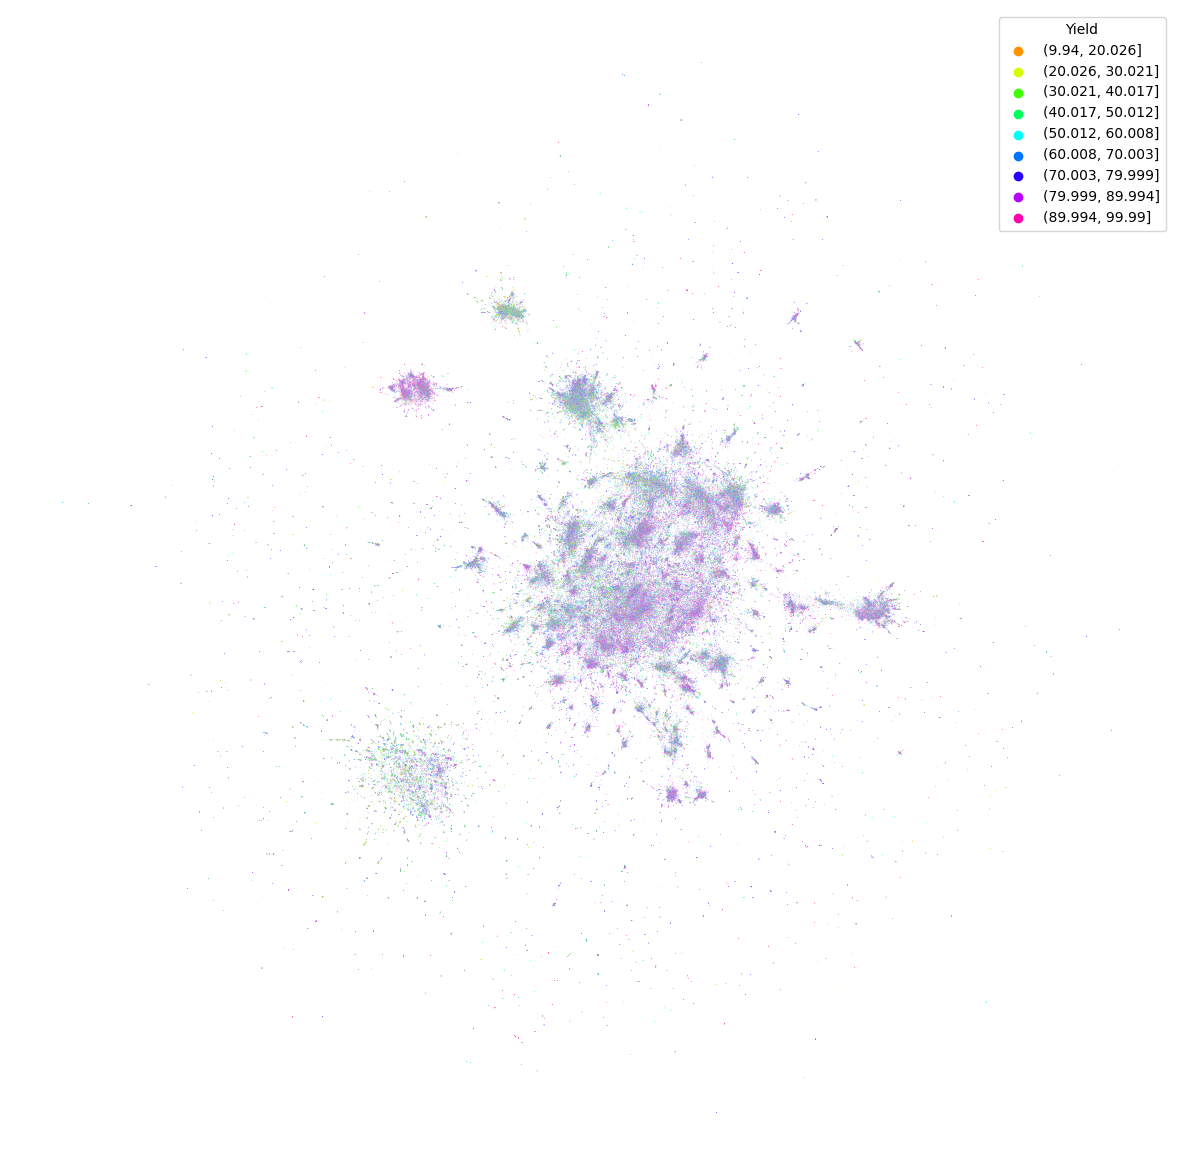

In [154]:
cl = classes[0]
cl_ = re.sub(" |-", "_", cl)

Xs = torch.load(f"../../data/processed/umap/UMAP_{cl_}_full.pt")
labels = sg_df_.loc[sg_df_["sgm_cls"] == cl, "Yield"]

# Get only those with yield > 0
discr = (labels > 10) * (~labels.isna())
Xs = Xs[discr]
labels = pd.cut(labels[discr], 9)

fig = plot_umap(
    Xs, labels=labels, save=f"../plots/{cl}_full_yield.png", dpi=600, s=0.3
)
figs.append(fig)